#  **Modelos supervisados para diagnosticar diabetes utilizando métodos ópticos no invasivos**



##  **Librerías utilizadas**

In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats


# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_blobs
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
import multiprocessing
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from google.colab import drive

from collections import Counter
from numpy.random import RandomState
from imblearn.over_sampling import SMOTE

# Configuración warnings
# ==============================================================================
#import warnings
#warnings.filterwarnings('once')

# Variables globales
semilla = 42

## **Análisis descriptivo**

### **Leer los datos del archivo**

In [ ]:

drive.mount('/content/drive')

df_base=pd.read_csv("drive/MyDrive/TFM/DataSetProd.csv")
display(df_base.head(5))

Mounted at /content/drive


,AF365,AF450,35 deg,42 deg,grupo
0,2.320158,1.229614,13.01,19.39,Control
1,1.529274,0.616514,8.18,24.78,Control
2,1.908257,0.955847,7.75,16.90,Control
3,1.590625,1.018495,4.10,16.30,Control
4,1.617071,1.242961,5.76,21.05,Control


### **Variables numéricas**

In [ ]:
datos_numericos = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_var_numericas = df_base.select_dtypes(include=datos_numericos).copy()
df_var_numericas.head(5)

,AF365,AF450,35 deg,42 deg
0,2.320158,1.229614,13.01,19.39
1,1.529274,0.616514,8.18,24.78
2,1.908257,0.955847,7.75,16.90
3,1.590625,1.018495,4.10,16.30
4,1.617071,1.242961,5.76,21.05


#### Se verifican el valor mínimo, el máximo, la mediana y la media, de las variables numéricas

In [ ]:
df_quartiles=df_var_numericas.describe()
display(df_quartiles)

,AF365,AF450,35 deg,42 deg
count,124.000000,124.000000,124.000000,124.000000
mean,2.575719,1.683305,7.269597,14.861048
std,0.814076,0.731116,2.899653,5.746477
min,0.410494,0.270591,2.100000,3.700000
25%,2.061781,1.292338,5.457500,10.552500
50%,2.550161,1.633922,6.700000,14.675000
75%,3.051504,1.942651,8.630000,18.592500
max,4.855556,6.458824,17.290000,32.480000


En este caso no se observan valores faltantes en las variables neméricas

In [ ]:
col_total_nulos = df_var_numericas.isnull().sum()
serie_col_nombres = col_total_nulos[col_total_nulos > 0]
display(serie_col_nombres)

Series([], dtype: int64)

#### Verificar valores atípicos

AF365 F1:  0.5771965720000005 F3:  4.536089135999999
AF450 F1:  0.3168678017500006 F3:  2.9181208117499997
35 deg F1:  0.6987499999999978 F3:  13.388750000000002
42 deg F1:  -1.507500000000002 F3:  30.652500000000003


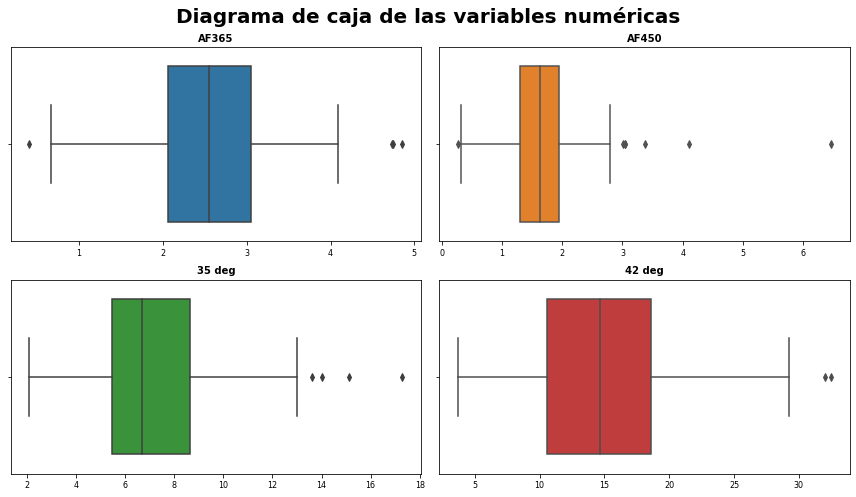

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))
axes = axes.flat

def boxplot(df):
  i=0
  for colum in df:
    sns.boxplot(
        x       = df[colum],
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        ax=axes[i])
    axes[i].set_title(colum, fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    i+=1

    # encontrar Q1, Q3 y rango intercuartílico para cada columna
    Q1 = df.quantile (q = .25)[colum]
    Q3 = df.quantile (q = .75)[colum]
    IQR = df.apply (stats.iqr)[colum]
    F1 = Q1-1.5*IQR
    F3 = Q3+1.5*IQR
    print(colum, 'F1: ', F1, 'F3: ',F3)
    
    

boxplot(df_var_numericas)
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Diagrama de caja de las variables numéricas', fontsize = 20, fontweight = "bold");



#### De acuerdo con el grafico, sobre la dispersión de los datos se observar que la variable AF450 se encuentra menos dispersas que las demás. Por otro lado, sobre los valores atípicos, de acuerdo con límite inferior f1 y límite superior f3 (calculado por el método de rango intercuartílico), si existen valores atípicos en el conjunto de datos, por lo que podrían hacer ruido en los modelos a crear.

#### Distribución de variables númericas para verificar si existe simetría

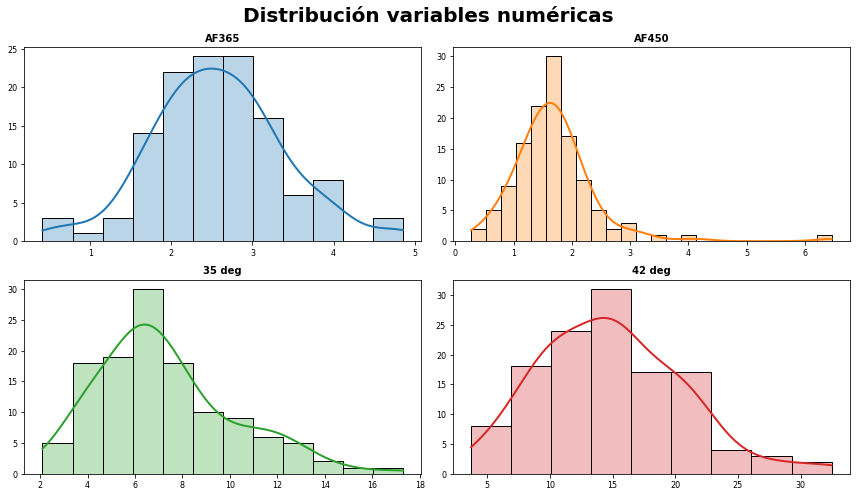

In [ ]:
def histograma(df):
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))
  axes = axes.flat

  for i, colum in enumerate(df):
      sns.histplot(
          
          data    = df,
          x       = colum,
          stat    = "count",
          kde     = True,
          color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
          line_kws= {'linewidth': 2},
          alpha   = 0.3,
          ax      = axes[i]
      )
      axes[i].set_title(colum, fontsize = 10, fontweight = "bold")
      axes[i].tick_params(labelsize = 8)
      axes[i].set_xlabel("")
      axes[i].set_ylabel("")
      
  fig.tight_layout()
  plt.subplots_adjust(top = 0.9)
  fig.suptitle('Distribución variables numéricas', fontsize = 20, fontweight = "bold");
histograma(df_var_numericas)

#### De acuerdo con los histogramas se observan que las variables se encuentran algo simétricas

#### Tratamiento de valores atípicos por el método de rango intercuartílico

In [ ]:
display(df_base.shape)
# encontrar Q1, Q3 y rango intercuartílico para cada columna
Q1 = df_var_numericas.quantile (q = .25)
Q3 = df_var_numericas.quantile (q = .75)
IQR = df_var_numericas.apply (stats.iqr)

# solo mantenga las filas en el marco de datos que tengan valores dentro de 1.5 * IQR de Q1 y Q3
df_clean = df_base [~ ((df_base <(Q1-1.5 * IQR)) | (df_base> (Q3 + 1.5 * IQR))). any (axis = 1)]
df_atipica = df_base [ ((df_base <(Q1-1.5 * IQR)) | (df_base> (Q3 + 1.5 * IQR))). any (axis = 1)]
df_clean_numerica=df_clean.select_dtypes(include=datos_numericos).copy()
# encontrar cuántas filas quedan en el marco de datos 
display(df_clean_numerica.shape)
df_atipica

(124, 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  if __name__ == '__main__':


(111, 4)

,AF365,AF450,35 deg,42 deg,grupo
12,0.410494,0.270591,3.91,16.32,Control
13,2.818713,1.271639,15.13,32.48,Control
15,2.406667,1.475761,14.00,22.00,Control
21,2.603687,1.554795,17.29,29.27,Control
24,2.063241,0.833135,11.64,32.04,Control
52,3.060000,1.600000,13.61,15.28,Diabetes
76,3.000000,3.005682,11.52,14.17,Diabetes
104,2.074074,6.458824,7.41,13.98,Diabetes
116,4.855556,1.835308,4.02,6.43,Diabetes_c
117,4.743590,3.377668,3.43,3.94,Diabetes_c


#### Se observa que se eliminaron 13 observaciones atípicas. Graficamos el digrama de caja y el hitograma de nuevo 

AF365 F1:  0.5927511962499996 F3:  4.42834928225
AF450 F1:  0.40316063675000025 F3:  2.7722037867499996
35 deg F1:  1.4074999999999989 F3:  12.467500000000001
42 deg F1:  -1.4274999999999967 F3:  30.472499999999997


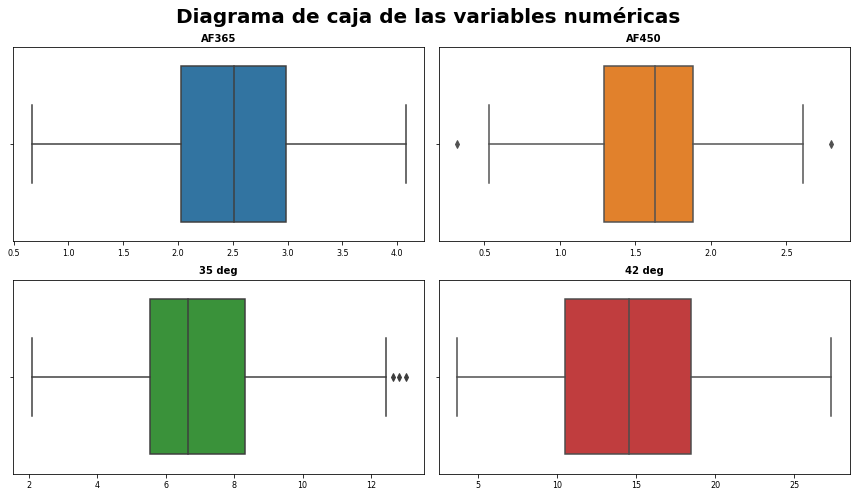

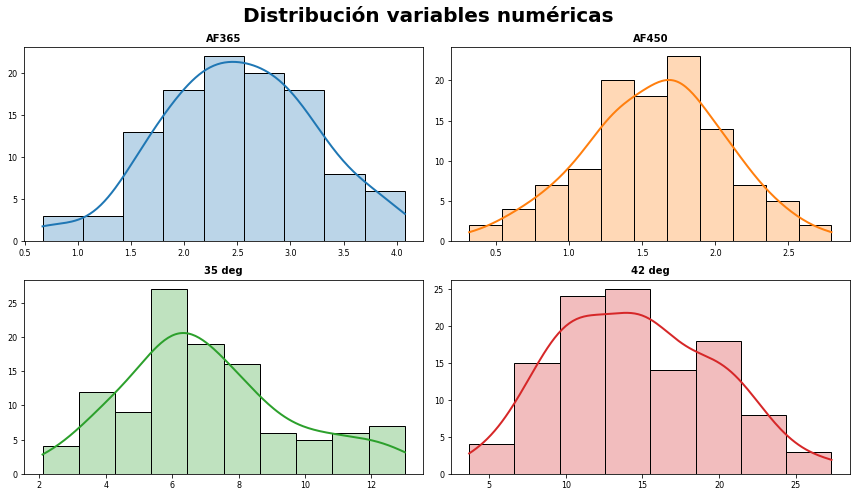

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))
axes = axes.flat 

boxplot(df_clean_numerica)
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Diagrama de caja de las variables numéricas', fontsize = 20, fontweight = "bold");
histograma(df_clean_numerica)

Se puede observar en el digrama de caja, que ya no se muestran valores tan extremos y en el histograma los datos se encuentran más simetricos

#### **Correlación de las variables numéricas**

In [ ]:
corr_matrix=df_clean_numerica.corr()
display(corr_matrix)

,AF365,AF450,35 deg,42 deg
AF365,1.000000,0.666443,-0.216618,-0.517749
AF450,0.666443,1.000000,-0.188036,-0.581328
35 deg,-0.216618,-0.188036,1.000000,0.629634
42 deg,-0.517749,-0.581328,0.629634,1.000000


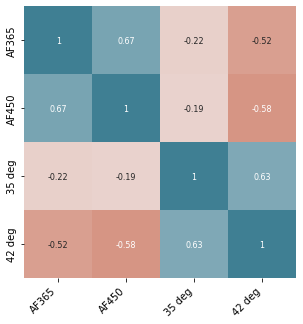

In [ ]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

#### Las variables de amplitud de fluorescencia se encuentra con una rrelación del 67% y las variables de perfusión cuenta con una relación del 63%. Tienen sentido ya que tienen la misma unidad de medida

### **Variables no numéricas**

In [ ]:

df_var_no_numericas = df_clean[df_clean.columns.difference(df_var_numericas.columns)].copy()
df_var_no_numericas.head(5)

,grupo
0,Control
1,Control
2,Control
3,Control
4,Control


#### Se verifican las diferentes categorías con su respectiva frecuencia , de las variables categóricas

In [ ]:
display(df_var_no_numericas.describe())
grupo=df_var_no_numericas['grupo']

,grupo
count,111
unique,3
top,Diabetes
freq,59


#### En este caso tampoco hay columnas que tengan datos faltantes

In [ ]:
total_no_numericas = df_var_no_numericas.isna().sum()
serie_col_nombres = total_no_numericas[total_no_numericas > 0]
display(serie_col_nombres)

Series([], dtype: int64)

#### Tabla de frecuencia 

In [ ]:
pd.value_counts(grupo)

Diabetes      59
Control       43
Diabetes_c     9
Name: grupo, dtype: int64

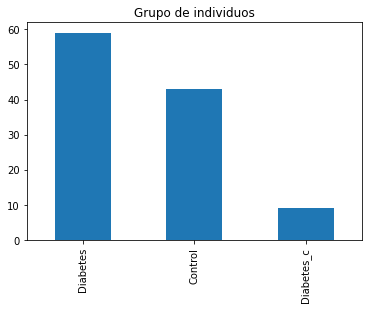

In [ ]:

plot = grupo.value_counts().plot(kind='bar',
                                            title='Grupo de individuos')

#### Tabla de frecuencia relativa

In [ ]:
100 * grupo.value_counts() / len(grupo)

Diabetes      53.153153
Control       38.738739
Diabetes_c     8.108108
Name: grupo, dtype: float64

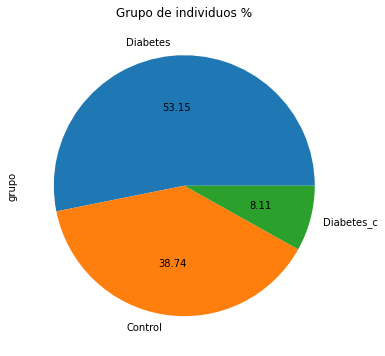

In [ ]:
plot = grupo.value_counts().plot(kind='pie', autopct='%.2f', 
                                            figsize=(6, 6),
                                            title='Grupo de individuos %')

Se observan que los datos se encuentran desbalanceados

## **Parametrización**

* Se segmenta los datos en dos conjuntos uno de entrenamiento con el 70% y de prueba 30% del total de datos respectivamente.

In [ ]:
train_x,test_x,train_y,test_y=train_test_split(df_clean.drop(columns = 'grupo'),df_clean['grupo'],test_size=0.3, random_state = semilla,stratify=df_clean['grupo'])
print('Dataset test shape %s' % Counter(test_y))
print(len(train_x))
print(len(train_y))

Dataset test shape Counter({'Diabetes': 18, 'Control': 13, 'Diabetes_c': 3})
77
77


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


### ***Funciones***

In [ ]:
def calcularGridSearchCV(estimador, parametros):
  grid = GridSearchCV(estimador, parametros,scoring="f1_weighted", n_jobs= multiprocessing.cpu_count() - 1, cv= 5)
    
  # fitting the model for grid search
  grid_search=grid.fit(train_x, train_y)
  print(grid_search.best_params_)
  predY_test=grid.predict(test_x)
  class_report=classification_report(test_y,predY_test)
  print(class_report)
  print('Accuracy Score testing: ' + str(accuracy_score(test_y,predY_test)))
  print('Accuracy Score training: ' + str(grid_search.best_score_))
  ConfusionMatrixDisplay.from_estimator(grid, test_x, test_y,cmap=plt.cm.Blues)

## **Aplicación de Data Augmentation Smote**


Dataset originial shape Counter({'Diabetes': 41, 'Control': 30, 'Diabetes_c': 6})
dataset remuestreado shape Counter({'Control': 41, 'Diabetes_c': 41, 'Diabetes': 41})
123
123


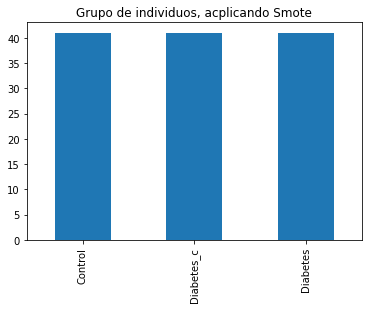

In [ ]:
print('Dataset originial shape %s' % Counter(train_y))
sm = SMOTE(random_state=semilla)
train_x, train_y = sm.fit_resample(train_x, train_y)
print('dataset remuestreado shape %s' % Counter(train_y))
plot = train_y.value_counts().plot(kind='bar',
                                            title='Grupo de individuos, acplicando Smote')
print(len(train_x))
print(len(train_y))

## **Entrenamiento con Arbol de decisión**

Se realiza el entrenamiento con Grid Search basado en out-of-bag score, contemplando los parametros por defecto

In [ ]:


# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {
                    'criterion'   : ['gini', 'entropy'],
                    'splitter'    : ['best', 'random'],
                    'max_depth'   : [None, 5,10,15,20,50,100],
                    'min_samples_split': [2,5,10,15, 20],
                    'min_samples_leaf': [1,2,5,10,15,20],
                    'max_features': [0.25,0.5, 0.75, 1],#['auto','sqrt', 'log2'],
                    'ccp_alpha':    [0.0,0.1, 0.01, 0.001,1],
                    'class_weight': ['balanced', None],
                 
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
  #class_weight={"Diabetes_c":3.5},
    tree_model = DecisionTreeClassifier(random_state=semilla,
                                             ** params)
    
    tree_model.fit(train_x, train_y)
    score=tree_model.score(test_x,test_y)
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(score)
    #print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(10)

,oob_accuracy,ccp_alpha,class_weight,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,splitter
19807,0.823529,0.010,None,entropy,50.0,0.75,1,15,random
18377,0.823529,0.010,None,gini,100.0,0.75,2,15,random
5177,0.823529,0.000,None,entropy,NaN,0.75,2,15,random
19577,0.823529,0.010,None,entropy,20.0,0.75,2,15,random
26767,0.823529,0.001,None,entropy,100.0,0.75,1,15,random
24367,0.823529,0.001,None,gini,15.0,0.75,1,15,random
18127,0.823529,0.010,None,gini,50.0,0.75,1,15,random
26047,0.823529,0.001,None,entropy,15.0,0.75,1,15,random
16927,0.823529,0.010,None,gini,NaN,0.75,1,15,random
26297,0.823529,0.001,None,entropy,20.0,0.75,2,15,random


              precision    recall  f1-score   support

     Control       0.80      0.92      0.86        13
    Diabetes       0.83      0.83      0.83        18
  Diabetes_c       1.00      0.33      0.50         3

    accuracy                           0.82        34
   macro avg       0.88      0.70      0.73        34
weighted avg       0.84      0.82      0.81        34

Accuracy Score : 0.8235294117647058


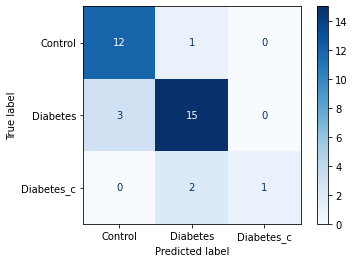

In [ ]:
tree_model = DecisionTreeClassifier(criterion='entropy',
                                    max_depth = 50,
                                    max_features=0.75,
                                    min_samples_leaf=1,
                                    min_samples_split=15,
                                    splitter='random',
                                    class_weight=None,
                                    ccp_alpha=0.010,
                                    random_state=semilla
                                    )
model=tree_model.fit(train_x,train_y)
predEY_clas_rnd=tree_model.predict(test_x)
class_report=classification_report(test_y,predEY_clas_rnd)
print(class_report)
print('Accuracy Score : ' + str(accuracy_score(test_y,predEY_clas_rnd)))
ConfusionMatrixDisplay.from_estimator(tree_model, test_x, test_y,cmap=plt.cm.Blues)

## **Entrenamiento con Random Forest**

Se realiza el entrenamiento con Grid Search basado en out-of-bag score, contemplando los parametros por defecto

In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {
                    'n_estimators':     [50,100,150,200],
                    'criterion'   :     ['gini', 'entropy'],
                    'max_depth'   :     [None,5,10,15,20,50],
                    'min_samples_split':[2, 5, 10,15,20],
                    'min_samples_leaf': [1,2, 5, 10,15,20],
                    'max_features': [0.25,0.5, 0.75, 1],#[None,'sqrt', 'log2'],
                    'class_weight': ['balanced', None],
                    'ccp_alpha':    [0.0,0.1, 0.01, 0.001],
                 
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state= semilla,
                ** params
             )
    
    modelo.fit(train_x, train_y)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    #print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(10)

,oob_accuracy,ccp_alpha,class_weight,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators
45509,0.910569,0.001,None,entropy,20.0,1.00,2,10,100
10589,0.910569,0.000,None,entropy,20.0,0.25,2,10,100
9629,0.910569,0.000,None,entropy,10.0,0.25,2,10,100
28349,0.910569,0.010,balanced,entropy,50.0,0.25,2,10,100
43229,0.910569,0.001,None,entropy,NaN,0.25,2,10,100
45029,0.910569,0.001,None,entropy,15.0,1.00,2,10,100
26309,0.910569,0.010,balanced,entropy,NaN,1.00,2,10,100
37469,0.910569,0.001,balanced,entropy,NaN,0.25,2,10,100
4709,0.910569,0.000,balanced,entropy,15.0,1.00,2,10,100
39389,0.910569,0.001,balanced,entropy,20.0,0.25,2,10,100


              precision    recall  f1-score   support

     Control       0.71      0.92      0.80        13
    Diabetes       0.86      0.67      0.75        18
  Diabetes_c       0.67      0.67      0.67         3

    accuracy                           0.76        34
   macro avg       0.74      0.75      0.74        34
weighted avg       0.78      0.76      0.76        34

Accuracy Score : 0.7647058823529411


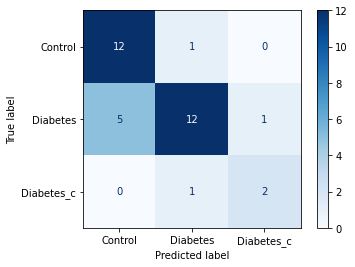

In [ ]:
new_clas_rndforest = RandomForestClassifier(max_depth=20,max_features=1,criterion='entropy',class_weight=None,random_state=semilla,min_samples_leaf=2,min_samples_split=10,n_estimators=100,ccp_alpha=0.001)
new_clas_rndforest.fit(train_x,train_y)
predEY_clas_rnd=new_clas_rndforest.predict(test_x)
class_report=classification_report(test_y,predEY_clas_rnd)
print(class_report)
print('Accuracy Score : ' + str(accuracy_score(test_y,predEY_clas_rnd)))
ConfusionMatrixDisplay.from_estimator(new_clas_rndforest, test_x, test_y,cmap=plt.cm.Blues)


## **Entrenamiento con SVM**

Se realiza el entrenamiento con Grid Search CV, contemplando los parametros por defecto

{'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__decision_function_shape': 'ovo', 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
              precision    recall  f1-score   support

     Control       0.77      0.77      0.77        13
    Diabetes       0.76      0.72      0.74        18
  Diabetes_c       0.50      0.67      0.57         3

    accuracy                           0.74        34
   macro avg       0.68      0.72      0.69        34
weighted avg       0.74      0.74      0.74        34

Accuracy Score testing: 0.7352941176470589
Accuracy Score training: 0.910145373237014


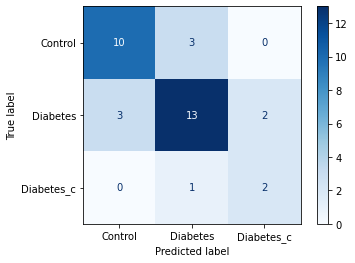

In [ ]:

new_ml = SVC(random_state =semilla) 
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('svc', new_ml)])

# defining parameter range
param_grid = {
              'svc__C': [ 0.1,1,5,10],
              'svc__kernel': ['linear','poly','rbf','sigmoid'], 
              'svc__gamma': ['scale', 'auto'],
              'svc__class_weight': ['balanced', None],
              "svc__decision_function_shape":['ovo', 'ovr']
              } 
  
calcularGridSearchCV(pipe,param_grid)

## **Entrenamiento con Red Neuronal (Multi-layer Perceptron classifier)**

Se realiza el entrenamiento con RandomizedSearchCV, contemplando los parametros por defecto

In [ ]:
# Pipeline de preprocedado y modelado
# ==============================================================================

# Identificación de columnas numéricas y categóricas
numeric_cols = train_x.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = train_x.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', MLPClassifier(solver = 'lbfgs', max_iter= 2100))])

In [ ]:
# Espacio de búsqueda de cada hiperparámetro
# ==============================================================================
param_distributions = {
    #'modelo__hidden_layer_sizes': [(100),(10), (20), (10, 10)],
    'modelo__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'modelo__activation': ['identity','logistic','tanh','relu'],
    'modelo__solver': ['lbfgs','sgd','adam'],
    'modelo__alpha': [0.0001,0.05],
    'modelo__learning_rate': ['constant','invscaling','adaptive']
}

# Búsqueda por validación cruzada
# ==============================================================================
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 50,
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 5, 
        random_state = semilla,
        return_train_score = True
       )

grid_search=grid.fit(X = train_x, y = train_y)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
140 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 752, in fit
    return self._fit(X, y, incremental=False)
  File 

In [ ]:
modelo_final = grid.best_estimator_

accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )
y_test_hat=modelo_final.predict(test_x)
test_accuracy=accuracy_score(test_y,y_test_hat)*100
test_accuracy
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )
modelo_final['modelo'].get_params()

Accuracy for our training dataset with tuning is : 90.23%
Accuracy for our testing dataset with tuning is : 70.59%


{'activation': 'tanh',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': 100,
 'learning_rate': 'invscaling',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 2100,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

              precision    recall  f1-score   support

     Control       0.67      0.77      0.71        13
    Diabetes       0.79      0.61      0.69        18
  Diabetes_c       0.60      1.00      0.75         3

    accuracy                           0.71        34
   macro avg       0.68      0.79      0.72        34
weighted avg       0.72      0.71      0.70        34

Accuracy Score testing: 0.7058823529411765


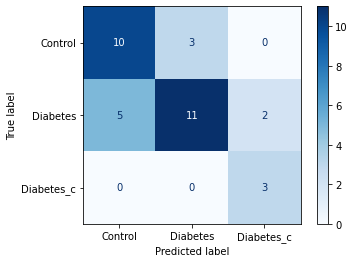

In [ ]:
confusion_matrix(test_y,y_test_hat)
#disp=plot_confusion_matrix(grid, test_x, test_y,cmap=plt.cm.Blues)
class_report=classification_report(test_y,y_test_hat)
print(class_report)
print('Accuracy Score testing: ' + str(accuracy_score(test_y,y_test_hat)))
ConfusionMatrixDisplay.from_estimator(modelo_final, test_x, test_y,cmap=plt.cm.Blues)

## **Entrenamiento con Nearest Neighbors Classification**

Se realiza el entrenamiento con Grid Search, contemplando los parametros por defecto

{'knn__algorithm': 'auto', 'knn__leaf_size': 30, 'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'distance'}
              precision    recall  f1-score   support

     Control       0.79      0.85      0.81        13
    Diabetes       0.85      0.61      0.71        18
  Diabetes_c       0.43      1.00      0.60         3

    accuracy                           0.74        34
   macro avg       0.69      0.82      0.71        34
weighted avg       0.79      0.74      0.74        34

Accuracy Score testing: 0.7352941176470589
Accuracy Score training: 0.8774480711582878


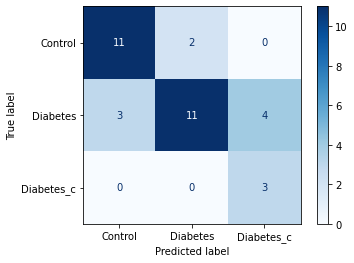

In [ ]:


knn = KNeighborsClassifier(n_jobs=-1)
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('knn', knn)])

# defining parameter range
param_grid = {
              'knn__n_neighbors': [ 5,10,20,20],
              'knn__weights': ['uniform','distance'], 
              'knn__algorithm': ['auto', 'ball_tree','kd_tree','brute'],
              'knn__leaf_size': [30,50,100],
              'knn__p': [1,2]
              } 
  
calcularGridSearchCV(pipe,param_grid)